## **Import libraries and packages**

In [ ]:
# %tensorflow_version 2.x

# import tensorflow and tensorflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# import ImageDataGenerator and the related functions required for processing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop

# import statements for building and loading the model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json

# import statements for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# import statements for initlializers and regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

# import statements for one-hot encoding, model plotting
from tensorflow.keras.utils import to_categorical, plot_model

# import statements for loading ResNet50 from keras
from tensorflow.keras.applications import resnet50
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input

# import statements for scikit-learn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.layers.experimental import preprocessing

# import scipy
import scipy.misc

# import os for file access
import os 

# import glob
import glob

# import numpy, pandas
import numpy as np
import pandas as pd

# import opencv
import cv2

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# import zipfile for unzipping the data
import zipfile

# import csv to access the csv files
import csv

# import drive to access the data from GDrive
from google.colab import drive

# import seaborn
import seaborn as sns

# import time
from time import time

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## **Load the dataset**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ChIA Images.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
data_dir = '/tmp/ChIA Images/'

## **Data Augmentation**

In [ ]:
training_batch_size = 16
validation_batch_size = 8
def get_images(img_size, preprocessing):

  
  datagen = ImageDataGenerator(rotation_range=20,
                              horizontal_flip= True,
                              height_shift_range=0.1,
                              width_shift_range=0.1,
                              shear_range=0.2,
                              zoom_range=0.2,
                              validation_split=0.2,
                              fill_mode="nearest",
                              preprocessing_function = preprocessing)
  
  train_datagen = datagen.flow_from_directory(data_dir,
                                            batch_size= training_batch_size,
                                            shuffle= True,
                                            target_size = (img_size, img_size),
                                            subset="training",
                                            class_mode = 'categorical')
  
  val_datagen = datagen.flow_from_directory(data_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            subset="validation",
                                            class_mode = 'categorical')
  
  return train_datagen, val_datagen

In [ ]:
train_datagen, val_datagen = get_images(224, preprocessing= resnet50.preprocess_input)

Found 498 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [ ]:
def visualize_training(history, epochs):
  fig = plt.figure()
  
  #plt.subplot(1,2,1)
  plt.plot(history.history['accuracy']);
  plt.plot(history.history['val_accuracy'])
  plt.title("Model Accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  #plt.figsize()
  label_1 = "{:.2f}".format(history.history['accuracy'][-1])
  label_2 = "{:.2f}".format(history.history['val_accuracy'][-1])
  plt.annotate(label_1, (epochs-1,history.history['accuracy'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.annotate(label_2, (epochs-1,history.history['val_accuracy'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.legend(['training', 'validation'], loc='upper left')

  fig = plt.figure()

  #plt.subplot(1,2,2)
  plt.plot(history.history['loss']);
  plt.plot(history.history['val_loss'])
  plt.title("Model Loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  label_3 = "{:.2f}".format(history.history['loss'][-1])
  label_4 = "{:.2f}".format(history.history['val_loss'][-1])
  plt.annotate(label_3, (epochs-1,history.history['loss'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.annotate(label_4, (epochs-1,history.history['val_loss'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.legend(['training', 'validation'], loc='upper left')

  plt.show()

In [ ]:
def print_classification_report(model, data_gen, batch_size):
  true_labels = data_gen.labels
  data_gen.reset()
  predicted_labels = model.predict(data_gen, steps = np.ceil(len(true_labels)/batch_size))
  #print(list( np.argmax(a) for a in predicted_labels), true_labels)
  print(classification_report(true_labels, list( np.argmax(a) for a in predicted_labels)))
  print("Confusion Matrix:\n ",confusion_matrix(true_labels,list( np.argmax(a) for a in predicted_labels)))

## **Build the model**

In [ ]:
resnet_base = resnet50.ResNet50(weights='imagenet', include_top= False, input_shape= (224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model = models.Sequential()
model.add(resnet_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, kernel_initializer='glorot_uniform', activation= 'relu'))
model.add(keras.layers.Dense(2, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 74,969,474
Trainable params: 74,916,354
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet_base.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 74,969,474
Trainable params: 51,381,762
Non-trainable params: 23,587,712
_________________________________________________________________


## **Compile the model**

In [ ]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath = '/content/drive/MyDrive/Model development/Iteration_3/iter3_resnet-model_1.h5',
        monitor = 'val_accuracy',
        save_best_only = True)]

## **Train the model**

In [ ]:
n_epochs = 4
history = model.fit(train_datagen,
                             steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                             epochs=n_epochs,
                             validation_data=val_datagen,
                             validation_steps=int(np.ceil(len(val_datagen.filenames)/validation_batch_size)))
                             #callbacks=callbacks_list)

Epoch 1/4
31/31 [==============================] - 44s 1s/step - loss: 0.9759 - accuracy: 0.6757 - val_loss: 0.8267 - val_accuracy: 0.7339
Epoch 2/4
31/31 [==============================] - 35s 1s/step - loss: 0.5921 - accuracy: 0.7978 - val_loss: 0.7507 - val_accuracy: 0.7258
Epoch 3/4
31/31 [==============================] - 35s 1s/step - loss: 0.4824 - accuracy: 0.8293 - val_loss: 0.5104 - val_accuracy: 0.7581
Epoch 4/4
31/31 [==============================] - 34s 1s/step - loss: 0.4150 - accuracy: 0.8403 - val_loss: 0.8018 - val_accuracy: 0.7742


## **Fine tune the model**

In [ ]:
resnet_base.trainable = True

In [ ]:
for layer in resnet_base.layers:
    if "conv5_block3_" in layer.name:
      layer.trainable = True
    else:
      layer.trainable = False

In [ ]:
for layer in resnet_base.layers:
  print(layer, layer.trainable, layer.name)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f32bf176470> False input_1
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f327405d748> False conv1_pad
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32747ceda0> False conv1_conv
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f327475f198> False conv1_bn
<tensorflow.python.keras.layers.core.Activation object at 0x7f3272a6b208> False conv1_relu
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f3272a7a908> False pool1_pad
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3272a81390> False pool1_pool
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3272eed358> False conv2_block1_1_conv
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3272a81eb8> False conv2_block1_1_bn
<tensorflow.python.keras.layers.core.Activation object at 0x7f3272f12cc0> False conv2_

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 74,969,474
Trainable params: 55,847,426
Non-trainable params: 19,122,048
_________________________________________________________________


In [ ]:
learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
n_epochs = 20
history = model.fit(train_datagen,
                             steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                             epochs=n_epochs,
                             validation_data=val_datagen,
                             validation_steps=int(np.ceil(len(val_datagen.filenames)/validation_batch_size)),
                             callbacks=callbacks_list)

Epoch 1/20
31/31 [==============================] - 38s 1s/step - loss: 0.5070 - accuracy: 0.7995 - val_loss: 0.6790 - val_accuracy: 0.7581
Epoch 2/20
31/31 [==============================] - 35s 1s/step - loss: 0.4225 - accuracy: 0.8077 - val_loss: 0.6618 - val_accuracy: 0.7581
Epoch 3/20
31/31 [==============================] - 35s 1s/step - loss: 0.3760 - accuracy: 0.8341 - val_loss: 0.6755 - val_accuracy: 0.7581
Epoch 4/20
31/31 [==============================] - 35s 1s/step - loss: 0.3341 - accuracy: 0.8670 - val_loss: 0.6348 - val_accuracy: 0.8145
Epoch 5/20
31/31 [==============================] - 35s 1s/step - loss: 0.3023 - accuracy: 0.8857 - val_loss: 0.5192 - val_accuracy: 0.8065
Epoch 6/20
31/31 [==============================] - 35s 1s/step - loss: 0.2010 - accuracy: 0.9160 - val_loss: 0.5089 - val_accuracy: 0.8226
Epoch 7/20
31/31 [==============================] - 35s 1s/step - loss: 0.2102 - accuracy: 0.9080 - val_loss: 0.5481 - val_accuracy: 0.8226
Epoch 8/20
31/31 [==

## **Visualize the training process**

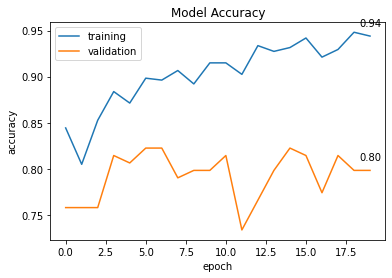

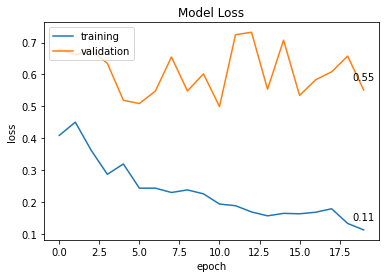

In [ ]:
visualize_training(history, n_epochs)

## **Load the saved model**

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/Model development/Iteration_3/iter3_resnet-model_1.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 74,969,474
Trainable params: 55,847,426
Non-trainable params: 19,122,048
_________________________________________________________________


## **Evaluate the model**

In [ ]:
_, evaluate_datagen = get_images(224, preprocessing= resnet50.preprocess_input)

Found 498 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [ ]:
model_result = loaded_model.evaluate(
    val_datagen,
    steps = 8)

8/8 [==============================] - 4s 498ms/step - loss: 0.2693 - accuracy: 0.9219


## **Classification Report**

In [ ]:
print_classification_report(loaded_model, evaluate_datagen,  validation_batch_size)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        98
           1       0.46      0.42      0.44        26

    accuracy                           0.77       124
   macro avg       0.65      0.65      0.65       124
weighted avg       0.77      0.77      0.77       124

Confusion Matrix:
  [[85 13]
 [15 11]]
